In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

## Pretraitement

In [31]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

In [32]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               112176 non-null  float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

## Prédiction de performance pour les coureurs en 2019

In [34]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    country_to_predict = race_to_predict.iloc[0]['country_code']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        total_races = 0
        avg_relative_rank = 1
        avg_rank = 10000
        max_relative_rank = 1
        min_relative_rank = 1
        
        total_elevation = 0
        avg_elevation = 0
        
        total_distance = 0
        avg_distance = 0
        min_distance = 0
        max_distance = 0
        
        total_eq_distance = 0
        avg_eq_distance = 0
        min_eq_distance = 0
        max_eq_distance = 0
        
        avg_runners = 0
        
        years_of_activity = race_to_predict.year
        last_year_activity = race_to_predict.year
        
        
        
        
        has_run = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        avg_speed = 0
        last_course_speed = 0
        home_country = 0
        avg_speed = 0
        avg_equivalent_speed = 0
        
        if nationality == country_to_predict:
            home_country = 1
        
        if runner_past.size >= 1: 
            has_run = 1
            total_races = runner_past.shape[0]
            
            avg_relative_rank = runner_past.relative_ranking.mean()
            avg_rank = runner_past.ranking.mean()
            max_relative_rank = runner_past.relative_ranking.max()
            min_relative_rank = runner_past.relative_ranking.min()
            
            total_elevation = runner_past.elevation_gain.sum()
            avg_elevation = runner_past.elevation_gain.mean()
            
            total_distance =  runner_past.distance.sum()
            avg_distance = runner_past.distance.mean()
            min_distance = runner_past.distance.min()
            max_distance = runner_past.distance.max()
            
            total_eq_distance = runner_past.equivalent_distance.sum()
            avg_eq_distance = runner_past.equivalent_distance.mean()
            min_eq_distance = runner_past.equivalent_distance.min()
            max_eq_distance = runner_past.equivalent_distance.max()
            
            avg_runners = runner_past.frequency_in_ranking.mean()

            avg_speed = runner_past.equivalent_speed.mean()
            last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']
            
            years_of_activity = race_to_predict.year - runner_past.year.min()
            
            last_year_activity = runner_past.year.max()
            
            
            avg_speed = runner_past.speed.mean()
            avg_equivalent_speed = runner_past.equivalent_speed.mean()
            
            
#             for i in range(len(runner_past)):
#                 ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'last_year_activity': last_year_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        
                        'total_distance': total_distance,
#                         'distance_previous_year': distance_previous_year,
                        'has_run': has_run,
#                         'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
#                         'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                        'last_course_speed': last_course_speed,
                        'home_country': home_country
                       }, ignore_index = True)
        
        
    values_to_predict = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    values_to_predict = values_to_predict.drop_duplicates(subset=['runner_id'], keep='last')
    values_to_predict = values_to_predict.reset_index()
    
    #one_hot_gender = pd.get_dummies(df['gender'], prefix = "gender")
    #one_hot_nationality= pd.get_dummies(df['nationality'], prefix = "nat")
    # Drop column B as it is now encoded
    #df = df.drop('gender',axis = 1)
    #df = df.drop('nationality',axis = 1)
    # Join the encoded df
    #df = df.join(one_hot_gender)
    #df = df.join(one_hot_nationality)
    
    return df, values_to_predict

In [35]:
runner_p, dz = runner_profile(join,race, 39881)

100%|███████████████████████████████████████| 1557/1557 [00:29<00:00, 53.33it/s]


In [36]:
join_h = pd.merge(runner_p, dz, left_on="runner_id", right_on="runner_id", how="left")

In [37]:
join_h_filtered = join_h.loc[join_h.n_races >= 1]

In [38]:
runner_p = join_h_filtered.drop(columns=['index','ranking','relative_ranking','time_in_seconds'])
dz = join_h_filtered[['runner_id','ranking','relative_ranking','time_in_seconds']]

<AxesSubplot:>

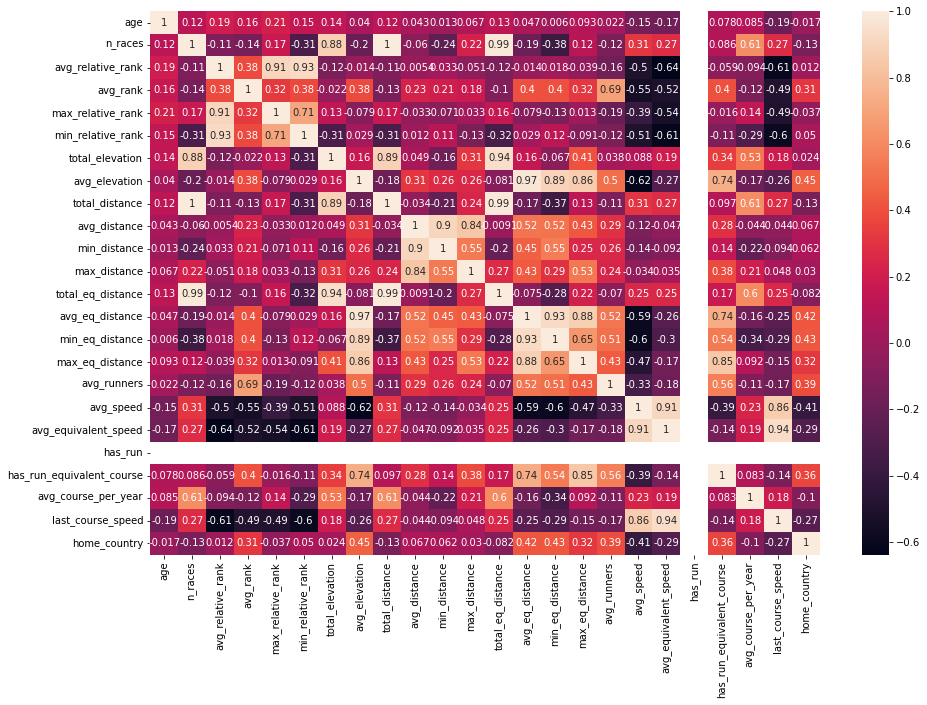

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(runner_p.corr(), annot=True)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = runner_p.drop(columns=['runner_id','gender','nationality'])

cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['ranking'] = dz.ranking
X['relative_ranking'] = dz.relative_ranking

sns.scatterplot(x = "axis1", y = "axis2", hue="relative_ranking",data = X)
~ plt.savefig('second_factorial_plan.pdf')


In [43]:
cls.explained_variance_ratio_

array([0.28332887, 0.21536673, 0.1539029 , 0.08139285, 0.05477312])

In [120]:
cls.components_

array([[ 7.20949338e-05,  1.23990312e-04, -2.00170827e-06,
        -5.29819254e-04,  2.46727903e-06, -5.09830064e-06,
         9.99005096e-01,  2.52428515e-02,  2.04523129e-02,
         2.03312977e-05, -8.55045750e-05,  1.20439179e-04,
         3.04423639e-02,  2.72759812e-04, -1.27999159e-04,
         6.81154281e-04,  2.38654970e-03,  7.60186374e-05,
         1.62805617e-05,  7.04242480e-06,  1.81567698e-05,
        -0.00000000e+00,  1.12123161e-05,  3.45174664e-05,
         1.91697959e-05,  8.26559176e-07],
       [-6.85337180e-05,  3.16918915e-04,  2.76722343e-07,
        -7.28656831e-02,  1.35088481e-05, -7.86770554e-06,
         2.24379010e-02, -9.69933089e-01,  5.01635341e-02,
        -8.41240019e-04, -1.05661958e-03, -5.53530101e-04,
         5.03879131e-02, -1.05405709e-02, -1.20646543e-02,
        -8.66471428e-03, -2.19151494e-01, -2.10372771e-06,
         1.29389955e-04,  3.45738555e-04,  1.99046323e-04,
        -0.00000000e+00, -1.52929486e-04,  1.11429605e-04,
         2.06

<AxesSubplot:xlabel='time_in_seconds', ylabel='Count'>

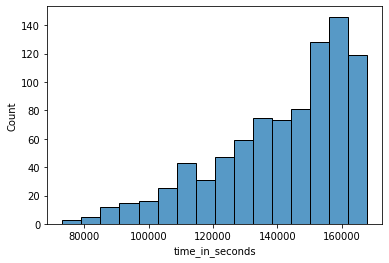

In [121]:
sns.histplot(x = dz.time_in_seconds)

In [122]:
runner_p

,runner_id,age,gender,nationality,n_races,avg_relative_rank,avg_rank,max_relative_rank,min_relative_rank,total_elevation,...,avg_runners,years_of_activity,last_year_activity,avg_speed,avg_equivalent_speed,has_run,has_run_equivalent_course,avg_course_per_year,last_course_speed,home_country
0,CAPELLPauESPM30.0,30.0,M,ESP,3.0,0.002780,3.000000,0.004630,0.001351,24780.0,...,1412.666667,"257 2 Name: year, dtype: int64",2019.0,8.405061,12.609136,1.0,1.0,1.500000,12.005744,0.0
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,6.0,0.006824,1.833333,0.026786,0.000390,57633.0,...,1438.333333,"257 6 Name: year, dtype: int64",2019.0,7.997199,12.569568,1.0,1.0,1.000000,12.347491,1.0
2,HAWKERScottNZLM34.0,34.0,M,NZL,2.0,0.022378,37.500000,0.040430,0.004327,19598.0,...,2062.500000,"257 5 Name: year, dtype: int64",2017.0,6.850133,10.849617,1.0,1.0,0.666667,12.239097,0.0
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,1.0,0.006294,16.000000,0.006294,0.006294,9980.0,...,2542.000000,"257 2 Name: year, dtype: int64",2017,7.457244,11.871437,1.0,1.0,0.000000,11.871437,0.0
6,WONGHoChungHKGM34.0,34.0,M,HKG,2.0,0.029366,29.500000,0.030142,0.028591,17260.0,...,1016.500000,"257 4 Name: year, dtype: int64",2016,6.357149,9.565375,1.0,1.0,2.000000,9.781865,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,KITAZAWASanaeJPNW54.0,54.0,W,JPN,3.0,0.771524,716.333333,0.954064,0.468243,26252.0,...,1017.666667,"257 6 Name: year, dtype: int64",2018,3.738099,5.707185,1.0,1.0,0.600000,5.645650,0.0
1549,NOMOTOTetsuroJPNM60.0,60.0,M,JPN,1.0,0.890884,645.000000,0.890884,0.890884,9164.0,...,724.000000,"257 6 Name: year, dtype: int64",2013,3.617684,5.676843,1.0,0.0,0.000000,5.676843,0.0
1552,CHUILokNinJoeHKGM42.0,42.0,M,HKG,2.0,0.723176,470.000000,0.870000,0.576351,15490.0,...,790.000000,"257 2 Name: year, dtype: int64",2018,3.733797,5.492483,1.0,0.0,2.000000,5.510851,0.0
1554,CLEMOTChristopheFRAM52.0,52.0,M,FRA,3.0,0.570148,1098.000000,0.625492,0.490411,26330.0,...,1824.000000,"257 2 Name: year, dtype: int64",2019,4.033878,6.081831,1.0,1.0,1.500000,6.360145,1.0


In [123]:
runner_p_quant = runner_p.drop(columns=['runner_id','gender','nationality'])
runner_p_quant.years_of_activity = runner_p_quant.years_of_activity.astype(int)
runner_p_quant.last_year_activity = runner_p_quant.last_year_activity.astype(int)
runner_p_quant = runner_p_quant.iloc[:,:28]
runner_p_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 0 to 1555
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        878 non-null    float64
 1   n_races                    878 non-null    float64
 2   avg_relative_rank          878 non-null    float64
 3   avg_rank                   878 non-null    float64
 4   max_relative_rank          878 non-null    float64
 5   min_relative_rank          878 non-null    float64
 6   total_elevation            878 non-null    float64
 7   avg_elevation              878 non-null    float64
 8   total_distance             878 non-null    float64
 9   avg_distance               878 non-null    float64
 10  min_distance               878 non-null    float64
 11  max_distance               878 non-null    float64
 12  total_eq_distance          878 non-null    float64
 13  avg_eq_distance            878 non-null    float6

In [124]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(runner_p_quant)),
    columns = runner_p.runner_id,
    index = runner_p.runner_id
)

In [3]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [126]:
mds_Xprime = MDS(n_components=2, dissimilarity='precomputed')
aftd_Xprime = mds_Xprime.fit_transform(X)

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

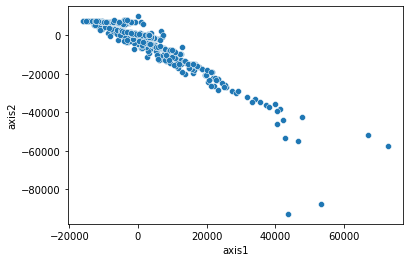

In [129]:
new_Xprime = pd.DataFrame(aftd_Xprime, columns=["axis1","axis2"])
sns.scatterplot(
    x = "axis1",
    y = "axis2",
    data = new_Xprime
)

In [130]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [131]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(df)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

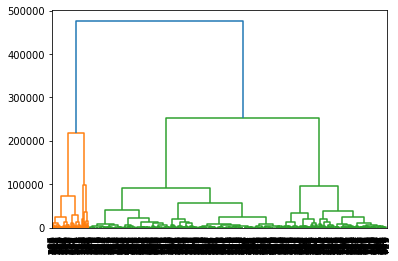

In [132]:
plot_dendrogram(cls)

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


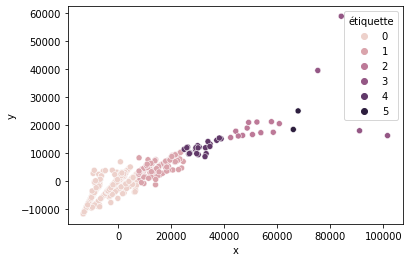

In [133]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=6
).fit(X)

labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)

new_df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette": labels})

sns.scatterplot("x", "y", hue="étiquette", data=new_df)
plt.show()

In [20]:
runner_p = runner_p.assign( label = labels)

<AxesSubplot:>

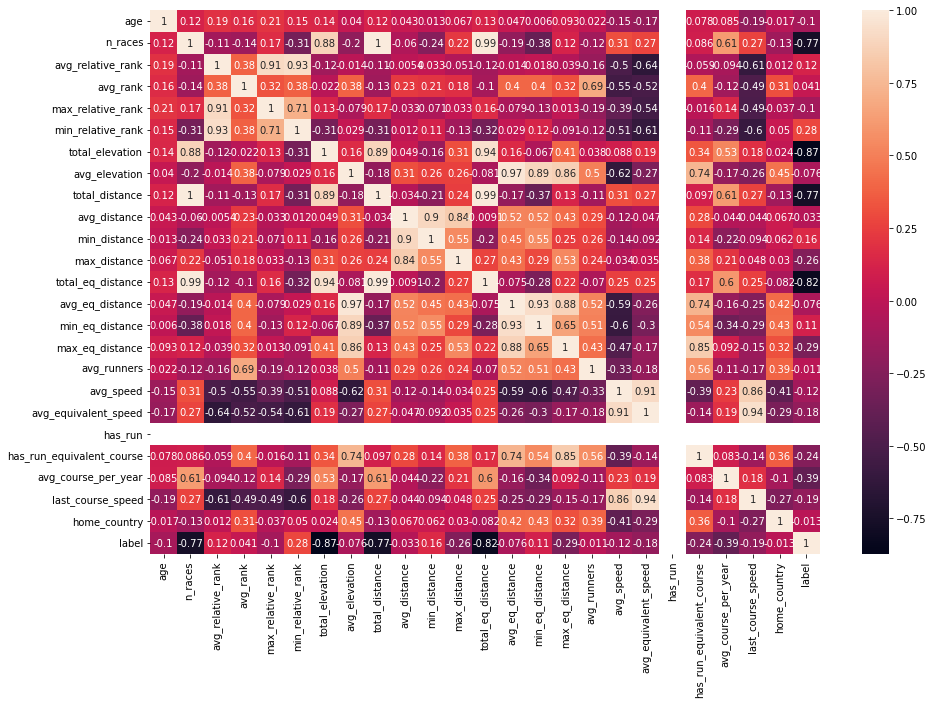

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(runner_p.corr(), annot=True)

# Test d'apprentissage KPPV

In [134]:
def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.linalg as linalg
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [52]:
Z = dz
X = runner_p.drop(columns=['runner_id','gender','nationality'])

In [53]:
def model_efficiency(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    for q in tqdm(np.arange(0.05,1,0.05)):
#         time_TH = Z.time_in_seconds.quantile(q)
#         Z = Z.assign( flag = Z.time_in_seconds > time_TH )
#         y = Z['flag'].astype(int)
#         df['quantile'] = pd.qcut(df['b'], 2, labels=False)
        
        y = pd.qcut(Z['time_in_seconds'], 2, labels=False)
       
        
        res_GS = clf.fit(X,y)

        ### PLOT PARAM test_score
        #sns.lineplot(
        #    x ='param_n_neighbors', 
        #    y = 'mean_test_score', 
        #    data = res_GS.cv_results_
        #)
        cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
        cls.fit(X,y)
        labels = cls.predict(X)
    
    
        res.append((q,accuracy_score(y, labels)))
    return res

In [54]:
def model_efficiency2(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    y = pd.qcut(Z['time_in_seconds'], 2, labels=False)


    res_GS = clf.fit(X,y)

    ## PLOT PARAM test_score
    sns.lineplot(
       x ='param_n_neighbors', 
       y = 'mean_test_score', 
       data = res_GS.cv_results_
    )
    
    cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
    cls.fit(X,y)
    labels = cls.predict(X)


    return accuracy_score(y, labels), labels


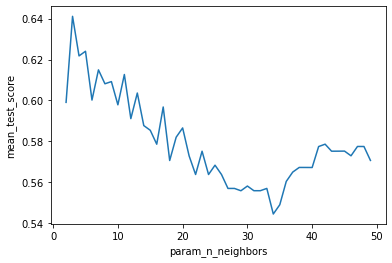

In [55]:
res, labels = model_efficiency2(X,Z)

In [56]:
res

0.816628701594533

### Test with KPPV

In [87]:
# y = pd.qcut(Z['time_in_seconds'], 2, labels=False)
time_TH = Z.time_in_seconds.quantile(0.3)
Z = Z.assign( flag = Z.time_in_seconds > time_TH )
y = Z['flag'].astype(int)

In [72]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [73]:
# def knn_cross_validation(X, y, n_folds, n_neighbors_list):
#     n = (n_folds - 1) / n_folds * len(y)
#     for n_neighbors in n_neighbors_list:
#         cls = KNeighborsClassifier(n_neighbors=n_neighbors)
#         for err in cross_val_score(cls, X, y, cv=n_folds):
#             yield (n_neighbors, err, n / n_neighbors)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import check_X_y

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.66)
# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

0.7224080267558528

In [89]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y_pred,y_test)

0.14950831770429104

# Multiple Regression

In [5]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [187]:
y = Z['time_in_seconds']

In [188]:
X2 = X.drop(columns=["label"])

KeyError: "['label'] not found in axis"

In [186]:
y = Z.time_in_seconds
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
LR = LinearRegression()
# LR = linear_model.Ridge(alpha=0.5)
# LR = linear_model.Lasso(alpha=0.1, max_iter=1000)
# LR = linear_model.LassoLars(alpha=.1, normalize=False)
# LR = ElasticNet(random_state=0, max_iter=1000000)
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)

ValueError: Found input variables with inconsistent numbers of samples: [2871, 878]

In [102]:
verify = pd.DataFrame({"real":y_test, "pred":y_prediction})

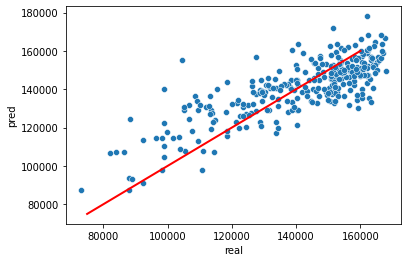

In [103]:
sns.scatterplot(
    x = "real",
    y = "pred",
    data = verify
)
plt.plot([75000, 160000], [75000, 160000], linewidth=2, color="red")

<AxesSubplot:xlabel='real', ylabel='Count'>

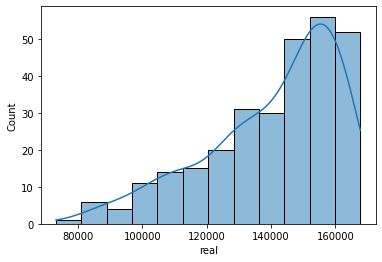

In [104]:
sns.histplot(x = verify.real, kde=True)

<AxesSubplot:ylabel='Count'>

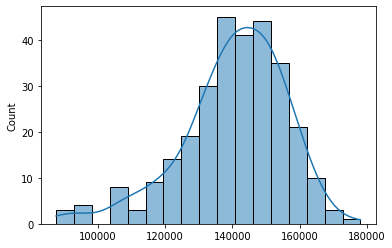

In [105]:
sns.histplot(x = y_prediction, kde=True)

# Get all runners historic

In [71]:
def all_runner_profile(join):
    #Collect data from course
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_past = join.loc[(join.runner_id == runner)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_past['age'].iloc[0]
        gender = runner_past['gender'].iloc[0]
        nationality = runner_past['nationality'].iloc[0]
        
        #Processed data        
        
        total_races = runner_past.shape[0]

        avg_relative_rank = runner_past.relative_ranking.mean()
        avg_rank = runner_past.ranking.mean()
        max_relative_rank = runner_past.relative_ranking.max()
        min_relative_rank = runner_past.relative_ranking.min()

        total_elevation = runner_past.elevation_gain.sum()
        avg_elevation = runner_past.elevation_gain.mean()

        total_distance =  runner_past.distance.sum()
        avg_distance = runner_past.distance.mean()
        min_distance = runner_past.distance.min()
        max_distance = runner_past.distance.max()

        total_eq_distance = runner_past.equivalent_distance.sum()
        avg_eq_distance = runner_past.equivalent_distance.mean()
        min_eq_distance = runner_past.equivalent_distance.min()
        max_eq_distance = runner_past.equivalent_distance.max()

        avg_runners = runner_past.frequency_in_ranking.mean()

        avg_speed = runner_past.equivalent_speed.mean()
        last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

        years_of_activity = runner_past.year.max() - runner_past.year.min()

        last_year_activity = runner_past.year.max()


        avg_speed = runner_past.speed.mean()
        avg_equivalent_speed = runner_past.equivalent_speed.mean()

        ranking_score = 0
        for i in range(len(runner_past)):
            ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

        year_interval = runner_past.year.max()- runner_past.year.min()
        avg_course_per_year = 0
        if year_interval != 0:
            avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        'total_distance': total_distance,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                       }, ignore_index = True)
    
    return df

In [304]:
runner_data = all_runner_profile(join)

100%|████████████████████████████████████| 64193/64193 [09:33<00:00, 111.93it/s]


In [305]:
from pathlib import Path  

filepath = Path('../../output/data_clean/runner_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

runner_data.to_csv(filepath)  

In [58]:
all_runners = pd.read_csv('../../output/data_clean/runner_data.csv', index_col=0)

<AxesSubplot:xlabel='count', ylabel='n_races'>

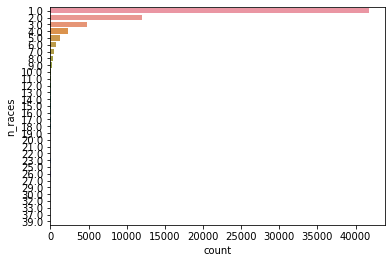

In [59]:
sns.countplot(
    y = all_runners.n_races
)

<AxesSubplot:xlabel='total_distance', ylabel='Count'>

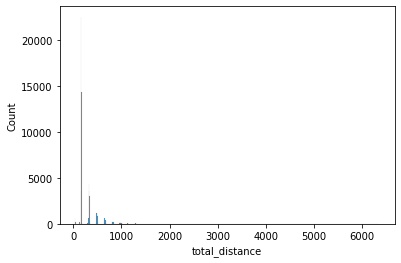

In [60]:
sns.histplot(
    x = all_runners.total_distance
)

Index(['age', 'n_races', 'avg_relative_rank', 'avg_rank', 'max_relative_rank',
       'min_relative_rank', 'total_elevation', 'avg_elevation',
       'total_distance', 'avg_distance', 'min_distance', 'max_distance',
       'total_eq_distance', 'avg_eq_distance', 'min_eq_distance',
       'max_eq_distance', 'avg_runners', 'years_of_activity', 'avg_speed',
       'avg_equivalent_speed', 'avg_course_per_year', 'ranking_score'],
      dtype='object')


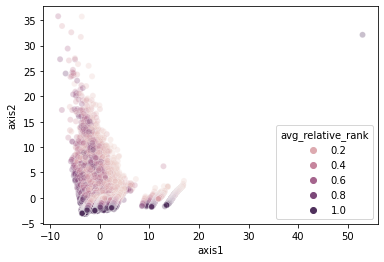

In [68]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = all_runners.drop(columns=['runner_id','gender','nationality'])
print(df.columns)

cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['avg_relative_rank'] = all_runners.avg_relative_rank
sns.scatterplot(x = "axis1", y = "axis2", hue="avg_relative_rank", data = X, alpha=0.3)
plt.savefig('../../../output/ACP_all_runners.pdf')


In [65]:
cls.explained_variance_ratio_

array([0.30708334, 0.24325127, 0.15360754, 0.093918  , 0.04183519])

In [66]:
cls.components_

array([[-4.41172302e-02, -6.38547287e-02, -2.73641375e-02,
        -1.94380702e-01, -4.47757037e-02, -9.74902800e-03,
        -1.81791009e-01, -3.10593606e-01, -8.34195387e-02,
        -2.91952394e-01, -2.79446685e-01, -2.95026855e-01,
        -1.16062544e-01, -3.62910546e-01, -3.43522989e-01,
        -3.62999810e-01, -2.08098228e-01, -7.72212463e-02,
         2.75384769e-01,  2.08924436e-01, -4.78460874e-02,
         2.24964774e-02],
       [ 1.71135896e-03,  3.95782756e-01, -1.67647880e-01,
        -1.28803072e-01, -6.64341218e-02, -2.39050450e-01,
         3.37791359e-01, -5.55365104e-02,  3.93542781e-01,
        -1.28816312e-02, -4.55657596e-02,  2.13984019e-02,
         3.88968961e-01, -4.81975708e-02, -1.10115075e-01,
         2.37474160e-02, -6.92789025e-02,  3.36219373e-01,
         1.50598042e-01,  1.62960316e-01,  2.79494821e-01,
         2.25454616e-01],
       [-1.86770711e-01, -1.61392001e-01, -4.71696187e-01,
        -1.48301107e-01, -4.99412420e-01, -4.06990999e-01,
    

In [14]:
def multiple_runner_profile(join, race, race_year_id_list):
    #Collect data from course
    #Return df
    huge_df = pd.DataFrame()
    
    for race_year_id_to_predict in tqdm(race_year_id_list):
        df = pd.DataFrame()
        race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
        race_year_id = race_to_predict.iloc[0]['race_year_id']
        date_to_predict = race_to_predict.iloc[0]['date']
        distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
        country_to_predict = race_to_predict.iloc[0]['country_code']


        unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
        for runner in unique_runners:
            
            runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
            runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
            
            if len(runner_past) >= 1:

                # Data processing
                #General data
                runner_id =  ''.join([runner, str(race_to_predict.race_year_id.iloc[0])])
                age = runner_info['age_course'].iloc[0]
                gender = runner_info['gender'].iloc[0]
                nationality = runner_info['nationality'].iloc[0]
                
                #Race information
                race_year_id = runner_info['race_year_id'].iloc[0]
                race_distance = runner_info['distance'].iloc[0]
                race_elevation_gain = runner_info['elevation_gain'].iloc[0]
                race_equivalent_distance = runner_info['equivalent_distance'].iloc[0]
                race_weighted_elevation = runner_info['weighted_elevation'].iloc[0]
                race_freq = runner_info['frequency_in_ranking'].iloc[0]
                

                #Processed data
                total_races = 0
                avg_relative_rank = 1
                max_relative_rank = 1
                min_relative_rank = 1

                total_elevation = 0
                avg_elevation = 0

                total_distance = 0
                avg_distance = 0
                min_distance = 0
                max_distance = 0

                total_eq_distance = 0
                avg_eq_distance = 0
                min_eq_distance = 0
                max_eq_distance = 0

                avg_runners = 0

                years_of_activity = race_to_predict.year
                last_year_activity = race_to_predict.year

                has_run = 0
                has_run_last_year = 0
                has_run_equivalent_course = 0
                avg_course_per_year = 0
                distance_previous_year = 0
                ranking_score = 0
                avg_speed = 0
                last_course_speed = 0
                home_country = 0
                avg_speed = 0
                avg_equivalent_speed = 0
                
                
                

                if nationality == country_to_predict:
                    home_country = 1

                has_run = 1
                total_races = runner_past.shape[0]

                avg_relative_rank = runner_past.relative_ranking.mean()
                avg_rank = runner_past.ranking.mean()
                max_relative_rank = runner_past.relative_ranking.max()
                min_relative_rank = runner_past.relative_ranking.min()

                total_elevation = runner_past.elevation_gain.sum()
                avg_elevation = runner_past.elevation_gain.mean()

                total_distance =  runner_past.distance.sum()
                avg_distance = runner_past.distance.mean()
                min_distance = runner_past.distance.min()
                max_distance = runner_past.distance.max()

                total_eq_distance = runner_past.equivalent_distance.sum()
                avg_eq_distance = runner_past.equivalent_distance.mean()
                min_eq_distance = runner_past.equivalent_distance.min()
                max_eq_distance = runner_past.equivalent_distance.max()

                avg_runners = runner_past.frequency_in_ranking.mean()

                avg_speed = runner_past.equivalent_speed.mean()
                last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

                years_of_activity = int(race_to_predict.year) - int(runner_past.year.min())

                last_year_activity = runner_past.year.max()


                avg_speed = runner_past.speed.mean()
                avg_equivalent_speed = runner_past.equivalent_speed.mean()


                for i in range(len(runner_past)):
                    ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

                if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                    has_run_equivalent_course = 1

                year_interval = runner_past.year.max()- runner_past.year.min()
                if year_interval != 0:
                    avg_course_per_year = total_races / year_interval



                df = df.append({'runner_id': runner_id,
                                'ranking': runner_info.iloc[0]['ranking'],
                                'relative_ranking': runner_info.iloc[0]['relative_ranking'],
                                'time_in_seconds': runner_info.iloc[0]['time_in_seconds'],
                                'age': age, 
                                'gender': gender, 
                                'nationality':nationality,
                                'n_races': total_races,
                                'ranking_score':ranking_score,
                                'avg_relative_rank': avg_relative_rank,
                                'max_relative_rank' : max_relative_rank,
                                'min_relative_rank' : min_relative_rank,
                                'total_elevation' : total_elevation,
                                'avg_elevation' : avg_elevation,
                                'total_distance' : total_distance,
                                'avg_distance' : avg_distance,
                                'min_distance' : min_distance,
                                'max_distance' : max_distance,
                                'total_eq_distance' : total_eq_distance,
                                'avg_eq_distance' : avg_eq_distance,
                                'min_eq_distance' : min_eq_distance,
                                'max_eq_distance' : max_eq_distance,
                                'avg_runners' : avg_runners,
                                'years_of_activity': years_of_activity,
                                'last_year_activity': last_year_activity,
                                'avg_speed': avg_speed,
                                'avg_equivalent_speed': avg_equivalent_speed,
                                'total_distance': total_distance,
                                'has_run': has_run,
                                'has_run_equivalent_course': has_run_equivalent_course,
                                'avg_course_per_year': avg_course_per_year,
                                'avg_speed': avg_speed,
                                'last_course_speed': last_course_speed,
                                'home_country': home_country,
                                'race_race_year_id' :race_year_id,
                                'race_distance' : race_distance,
                                'race_elevation_gain' : race_elevation_gain,
                                'race_equivalent_distance' : race_equivalent_distance,
                                'race_weighted_elevation' : race_weighted_elevation,
                                'race_freq' : race_freq
                               }, ignore_index = True)

        huge_df = huge_df.append(df, ignore_index=True)

                
    one_hot_gender = pd.get_dummies(huge_df['gender'], prefix = "gender")
    huge_df = huge_df.drop('gender',axis = 1)
    huge_df = huge_df.join(one_hot_gender)
    
    return huge_df

In [15]:
df = multiple_runner_profile(join, race, race.loc[race.year >= 2014].race_year_id.unique())

100%|█████████████████████████████████████████| 972/972 [18:23<00:00,  1.13s/it]


In [29]:
from pathlib import Path  

filepath = Path('../../output/data_clean/training_reg_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

df.to_csv(filepath)  

In [69]:
df2 = pd.read_csv('../../output/data_clean/training_reg_data.csv', index_col=0)

In [70]:
df2 = df2.loc[(df2.race_distance >= 120)]

### LinearRegression()

r2 score is  0.8011290551386652


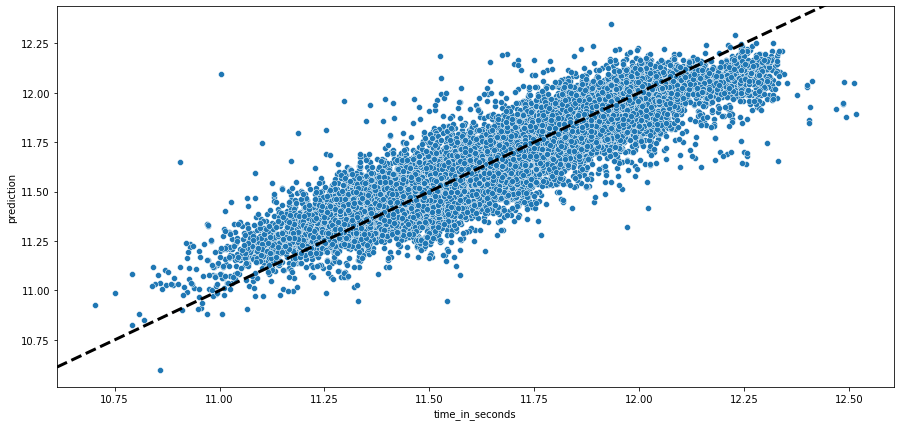

In [76]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
#  X = X[['age','n_races','avg_relative_rank','max_relative_rank','min_relative_rank','avg_speed',
#        'avg_equivalent_speed','last_course_speed','race_weighted_elevation','gender_M','gender_W']]

y = df2.time_in_seconds
y = np.log(y) 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
LR = LinearRegression()
# R = linear_model.Ridge(alpha=0.5)
# LR = linear_model.Lasso(alpha=0.1, max_iter=1000)
# LR = linear_model.LassoLars(alpha=.1, normalize=False)
# LR = ElasticNet(random_state=0, max_iter=10000)
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)
print('r2 score is ',score)

verify = pd.DataFrame({"time_in_seconds":y_test, "prediction":y_prediction})

plt.figure(figsize=(15,7))

ax = sns.scatterplot(
    x = "time_in_seconds",
    y = "prediction",
    data = verify
)
#plt.plot([75000, 160000], [75000, 160000], linewidth=2, color="red")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)

plt.savefig('../../../output/time_prediction.pdf')

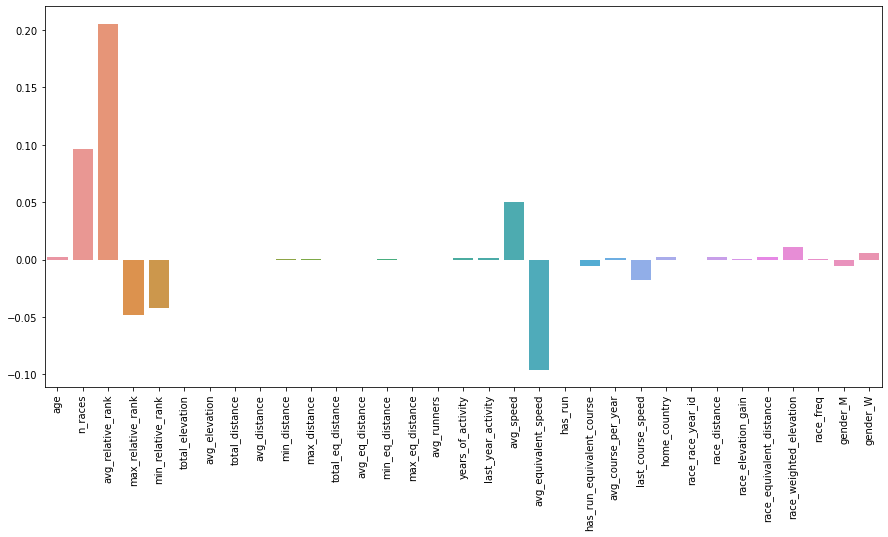

In [72]:
plt.figure(figsize=(15,7))
plt.xticks(rotation = 'vertical')
sns.barplot(x = X.columns.tolist(), y = LR.coef_ )

plt.savefig('../../../output/variables_contribution.pdf')

In [99]:
verify.time_in_seconds[0]

11.549710522012228

In [100]:
np.exp(verify.time_in_seconds[0])

103747.0

In [102]:
np.exp(verify.prediction[0])

107427.29280942223

In [73]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

0.7985067240194929


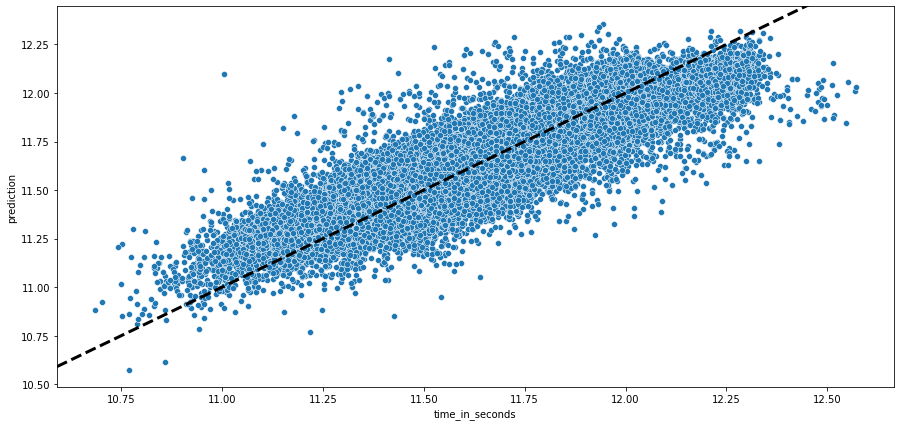

In [86]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
y = df2.time_in_seconds
y = np.log(y)

LR = LinearRegression()
predicted = cross_val_predict(LR, StandardScaler().fit_transform(X), y, cv=10)
print(r2_score(y, predicted))

verify = pd.DataFrame({"time_in_seconds":y, "prediction":predicted})
plt.figure(figsize=(15,7))
ax = sns.scatterplot( x = "time_in_seconds", y = "prediction", data = verify)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)

0.7984777314410889


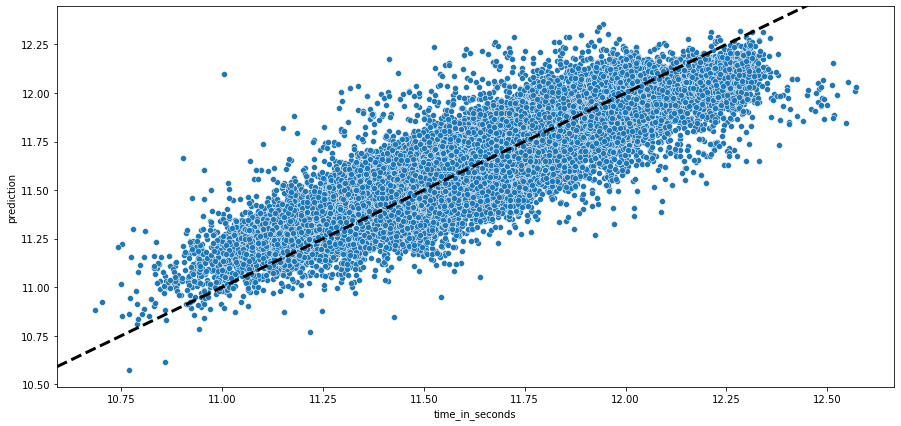

In [87]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
y = df2.time_in_seconds
y = np.log(y)

LR = linear_model.Ridge(alpha=0.5)
#LR = linear_model.Lasso(alpha=0.1, max_iter=1000)
#LR = linear_model.LassoLars(alpha=.1, normalize=False)
#LR = ElasticNet(random_state=0, max_iter=10000)
predicted = cross_val_predict(LR, StandardScaler().fit_transform(X), y, cv=10)
print(r2_score(y, predicted))

verify = pd.DataFrame({"time_in_seconds":y, "prediction":predicted})
plt.figure(figsize=(15,7))
ax = sns.scatterplot( x = "time_in_seconds", y = "prediction", data = verify)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)

0.7996458508669358


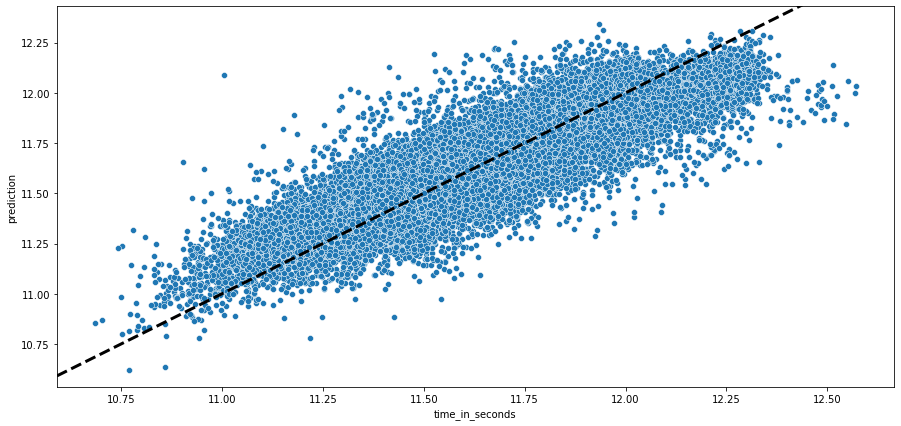

In [93]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
y = df2.time_in_seconds
y = np.log(y)

LR = linear_model.Lasso(alpha=0.001, max_iter=10000)
#LR = linear_model.LassoLars(alpha=.1, normalize=False)
#LR = ElasticNet(random_state=0, max_iter=10000)
predicted = cross_val_predict(LR, StandardScaler().fit_transform(X), y, cv=10)
print(r2_score(y, predicted))

verify = pd.DataFrame({"time_in_seconds":y, "prediction":predicted})
plt.figure(figsize=(15,7))
ax = sns.scatterplot( x = "time_in_seconds", y = "prediction", data = verify)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)

0.7996318503029073


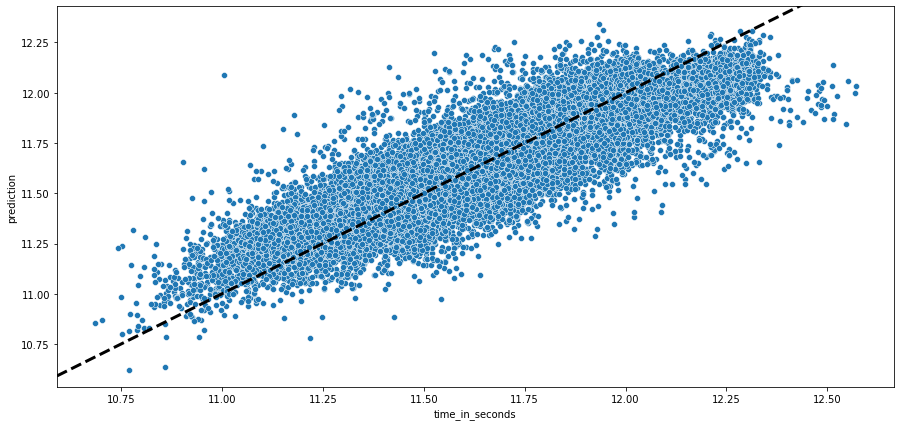

In [98]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
y = df2.time_in_seconds
y = np.log(y)

LR = linear_model.LassoLars(alpha=0.001, normalize=False)
#LR = ElasticNet(random_state=0, max_iter=10000)
predicted = cross_val_predict(LR, StandardScaler().fit_transform(X), y, cv=10)
print(r2_score(y, predicted))

verify = pd.DataFrame({"time_in_seconds":y, "prediction":predicted})
plt.figure(figsize=(15,7))
ax = sns.scatterplot( x = "time_in_seconds", y = "prediction", data = verify)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)

0.5504990765425448


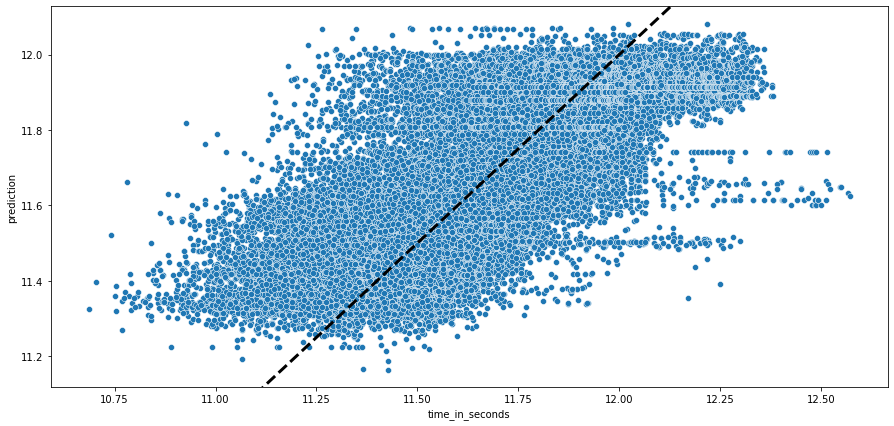

In [101]:
X = df2.drop(columns=['runner_id','ranking','relative_ranking','time_in_seconds','nationality'])
y = df2.time_in_seconds
y = np.log(y)

LR = ElasticNet(random_state=42, max_iter=10000)
predicted = cross_val_predict(LR, X, y, cv=10)
print(r2_score(y, predicted))

verify = pd.DataFrame({"time_in_seconds":y, "prediction":predicted})
plt.figure(figsize=(15,7))
ax = sns.scatterplot( x = "time_in_seconds", y = "prediction", data = verify)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='black', lw=3, scalex=False, scaley=False)